# Stabilize Flight1 Images
# This notebook shows how to apply the `stabilize_frames` pipeline from
# `baseline/model/baseline.py` to images in `data/images/Flight1` and save/visualize results.

# Steps:
# 1. Install / import dependencies
# 2. Load images
# 3. Run stabilization
# 4. Visualize and save outputs


In [ ]:
# Optional: install necessary packages (run this cell if cv2 / imageio / matplotlib are missing)
# In notebook environments use the pip magic so the environment used by the kernel is updated.
# Uncomment and run if you need to install packages.

# %pip install -q opencv-python-headless matplotlib imageio numpy

# Note: on macOS with a full desktop Jupyter you can use opencv-python instead of -headless to enable GUI windows.


In [3]:
# Imports and project path setup
import sys
import os
from pathlib import Path
import time
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Add project root so we can import baseline.model.baseline
project_root = Path("/Users/h33662/Projects/self/edth").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Now import the stabilization functions
try:
    from baseline.model.baseline import (
        stabilize_frames,
        warp_with_scale_translation,
        estimate_scale_translation,
    )
except Exception as e:
    print("Import error: ", e)
    print(
        "Make sure the project root is correct and that dependencies (cv2, numpy) are installed."
    )


In [4]:
# Helper functions: loading images and showing grids
from typing import List, Tuple


def load_images_from_folder(
    folder: Path, extensions=("*.png", "*.jpg", "*.jpeg", "*.bmp"), max_frames=None
) -> Tuple[List[np.ndarray], List[Path]]:
    files = []
    for ext in extensions:
        files.extend(sorted(folder.glob(ext)))
    files = sorted(files)
    if max_frames is not None:
        files = files[:max_frames]
    frames = []
    valid_paths = []
    for p in files:
        img = cv2.imread(str(p))  # BGR
        if img is None:
            print(f"Warning: failed to read {p}")
            continue
        frames.append(img)
        valid_paths.append(p)
    return frames, valid_paths


def show_grid(frames: List[np.ndarray], titles=None, cols=4, figsize=(12, 8)):
    if not frames:
        print("No frames to show")
        return
    n = len(frames)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, f in enumerate(frames):
        ax = plt.subplot(rows, cols, i + 1)
        rgb = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb)
        title = "" if titles is None else titles[i]
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [5]:
# Load images from Flight1 (adjust path as needed)
from pathlib import Path

INPUT_DIR = Path("/Users/h33662/Projects/self/edth/data/images/Flight1")
print("Input dir:", INPUT_DIR)
frames, paths = load_images_from_folder(INPUT_DIR, max_frames=9)
print(f"Loaded {len(frames)} frames")
if paths:
    for p in paths[:9]:
        print("-", p.name)


Input dir: /Users/h33662/Projects/self/edth/data/images/Flight1
Loaded 9 frames
- 00000000.jpg
- 00000001.jpg
- 00000002.jpg
- 00000003.jpg
- 00000004.jpg
- 00000005.jpg
- 00000006.jpg
- 00000007.jpg
- 00000008.jpg


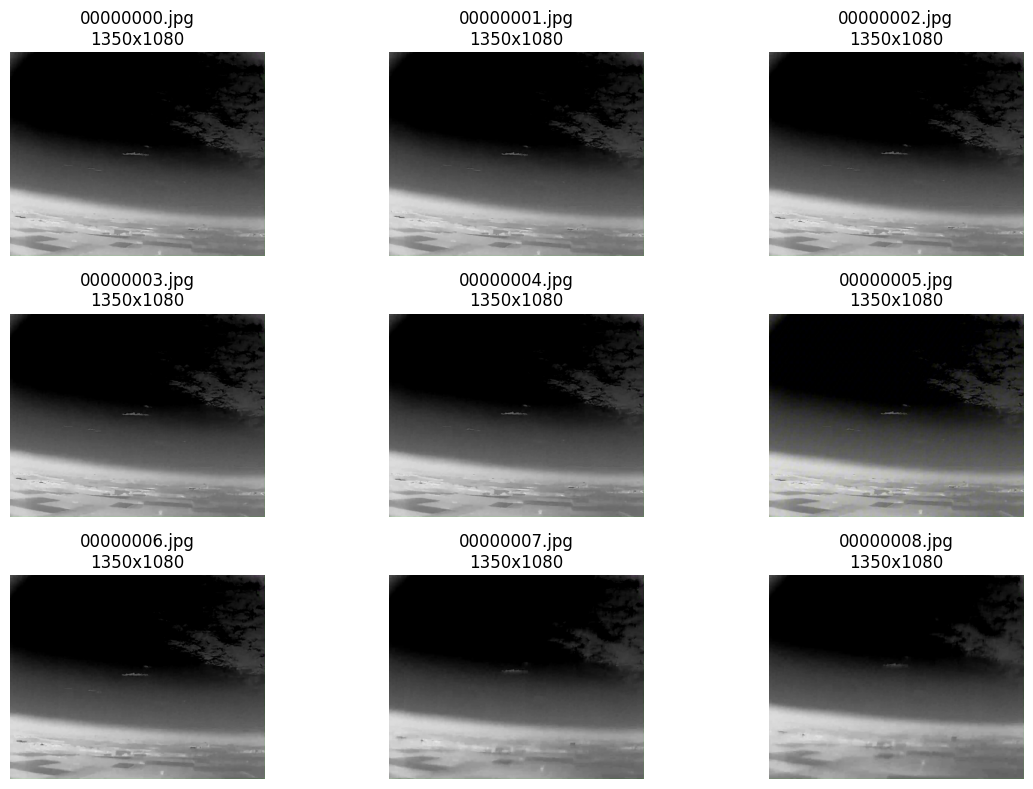

In [6]:
# Preview the first few input frames
if frames:
    titles = [f"{p.name}\n{f.shape[1]}x{f.shape[0]}" for p, f in zip(paths, frames)]
    show_grid(frames, titles=titles, cols=3, figsize=(12, 8))
else:
    print("No frames available to preview. Check the input directory and file formats.")


In [7]:
# Run stabilization on the loaded frames
if not frames:
    print("No frames loaded; skipping stabilization step")
else:
    t0 = time.time()
    res = stabilize_frames(frames, ref_idx=None)
    t1 = time.time()
    print(f"Stabilization call time: {t1 - t0:.3f}s")
    warped = res.get("warped", [])
    scales = res.get("scales", [])
    translations = res.get("translations", [])
    inliers = res.get("inliers", [])
    ref_idx = res.get("ref_idx", None)
    print(f"Ref idx: {ref_idx}, frames: {len(warped)}")


Feature matching time: 0.020s (LK, 956 matches)
Feature matching time: 0.012s (LK, 951 matches)
Feature matching time: 0.012s (LK, 1005 matches)
Feature matching time: 0.012s (LK, 1007 matches)
Feature matching time: 0.014s (LK, 1061 matches)
Feature matching time: 0.011s (LK, 895 matches)
Feature matching time: 0.009s (LK, 830 matches)
Feature matching time: 0.012s (LK, 497 matches)
Stabilization time: estimate 106.200ms, warp 6.437ms
Stabilization call time: 0.124s
Ref idx: 4, frames: 9


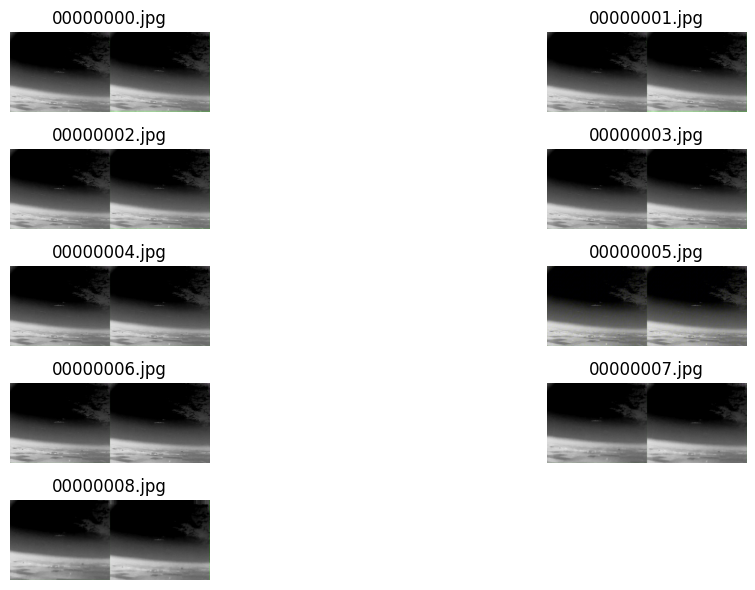

In [8]:
# Visualize before / after for each frame (side-by-side)
if warped:
    side_by_side = []
    titles = []
    for orig, w, p in zip(frames, warped, paths):
        # ensure same shape
        if orig.shape != w.shape:
            # resize warped to original shape if needed
            w = cv2.resize(w, (orig.shape[1], orig.shape[0]))
        combined = np.hstack((orig, w))
        side_by_side.append(combined)
        titles.append(p.name)

    # show a few
    show_grid(side_by_side, titles=titles, cols=2, figsize=(12, 6))
else:
    print("No warped frames to display")


In [ ]:
# Save warped frames and write a video/gif
OUTPUT_DIR = INPUT_DIR / "stabilized_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

saved_paths = []
if warped:
    for p, w in zip(paths, warped):
        out_name = OUTPUT_DIR / f"stabilized_{p.name}"
        cv2.imwrite(str(out_name), w)
        saved_paths.append(out_name)
    print(f"Saved {len(saved_paths)} frames to", OUTPUT_DIR)

    # Save mp4 using imageio (convert to RGB)
    try:
        video_path = OUTPUT_DIR / "stabilized.mp4"
        with imageio.get_writer(str(video_path), fps=15, codec="libx264") as writer:
            for w in warped:
                rgb = cv2.cvtColor(w, cv2.COLOR_BGR2RGB)
                writer.append_data(rgb)
        print("Wrote video to", video_path)
    except Exception as e:
        print("Failed to write mp4 with imageio:", e)

    # Save a small GIF for quick preview (reduced size)
    try:
        gif_path = OUTPUT_DIR / "stabilized_preview.gif"
        imgs = [
            cv2.cvtColor(
                cv2.resize(w, (w.shape[1] // 2, w.shape[0] // 2)), cv2.COLOR_BGR2RGB
            )
            for w in warped
        ]
        imageio.mimsave(str(gif_path), imgs, fps=6)
        print("Wrote GIF to", gif_path)
    except Exception as e:
        print("Failed to write GIF:", e)
else:
    print("No warped frames to save")


[ WARN:0@517.209] global loadsave.cpp:1117 imwrite_ imwrite_('/Users/h33662/Projects/self/edth/data/images/Flight1/stabilized_outputs/stabilized_00000000.jpg'): can't open file for writing: permission denied
[ WARN:0@517.210] global loadsave.cpp:1117 imwrite_ imwrite_('/Users/h33662/Projects/self/edth/data/images/Flight1/stabilized_outputs/stabilized_00000001.jpg'): can't open file for writing: permission denied
[ WARN:0@517.210] global loadsave.cpp:1117 imwrite_ imwrite_('/Users/h33662/Projects/self/edth/data/images/Flight1/stabilized_outputs/stabilized_00000002.jpg'): can't open file for writing: permission denied
[ WARN:0@517.211] global loadsave.cpp:1117 imwrite_ imwrite_('/Users/h33662/Projects/self/edth/data/images/Flight1/stabilized_outputs/stabilized_00000003.jpg'): can't open file for writing: permission denied
[ WARN:0@517.211] global loadsave.cpp:1117 imwrite_ imwrite_('/Users/h33662/Projects/self/edth/data/images/Flight1/stabilized_outputs/stabilized_00000004.jpg'): can't o

Saved 9 frames to /Users/h33662/Projects/self/edth/data/images/Flight1/stabilized_outputs


In [ ]:
# Batch processing wrapper


def process_folder(input_dir: Path, output_dir: Path, max_frames=None, ref_idx=None):
    t0 = time.time()
    frames, paths = load_images_from_folder(input_dir, max_frames=max_frames)
    if not frames:
        raise RuntimeError("No frames found in " + str(input_dir))
    res = stabilize_frames(frames, ref_idx=ref_idx)
    warped = res.get("warped", [])
    output_dir.mkdir(parents=True, exist_ok=True)
    for p, w in zip(paths, warped):
        out_name = output_dir / f"stabilized_{p.name}"
        cv2.imwrite(str(out_name), w)
    t1 = time.time()
    print(f"Processed {len(warped)} frames in {t1 - t0:.3f}s")
    return {
        "input_dir": input_dir,
        "output_dir": output_dir,
        "num_frames": len(warped),
        "time_s": t1 - t0,
        "res": res,
    }


# Example run; comment out if running interactively step-by-step
# out = process_folder(INPUT_DIR, INPUT_DIR / 'stabilized_batch', max_frames=50)
# print(out)


In [ ]:
# Basic runtime checks / assertions
if frames and warped:
    assert len(warped) == len(frames), "mismatch in number of warped frames"
    if ref_idx is not None:
        assert warped[ref_idx].shape == frames[ref_idx].shape, (
            "reference frame shape changed"
        )
    assert all(isinstance(s, float) for s in scales), "scales should be floats"
    print("Basic checks passed")
else:
    print("Skipping runtime checks (no frames or no warped frames)")
